In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import geopandas as gpd


### EDA 

#### Read data

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


#### Plot graphs

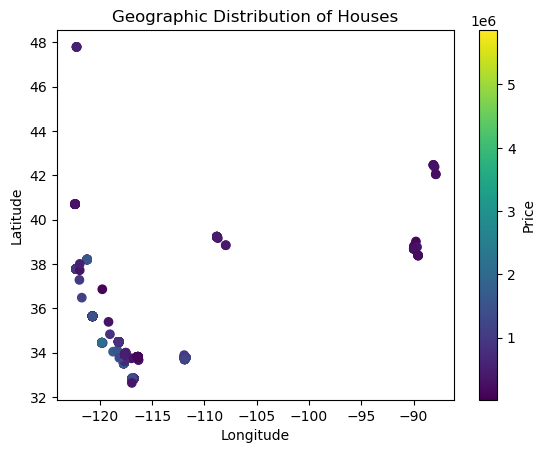

In [5]:
plt.scatter(df['Longitude'], df['Latitude'], 
            c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographic Distribution of Houses")
plt.show()


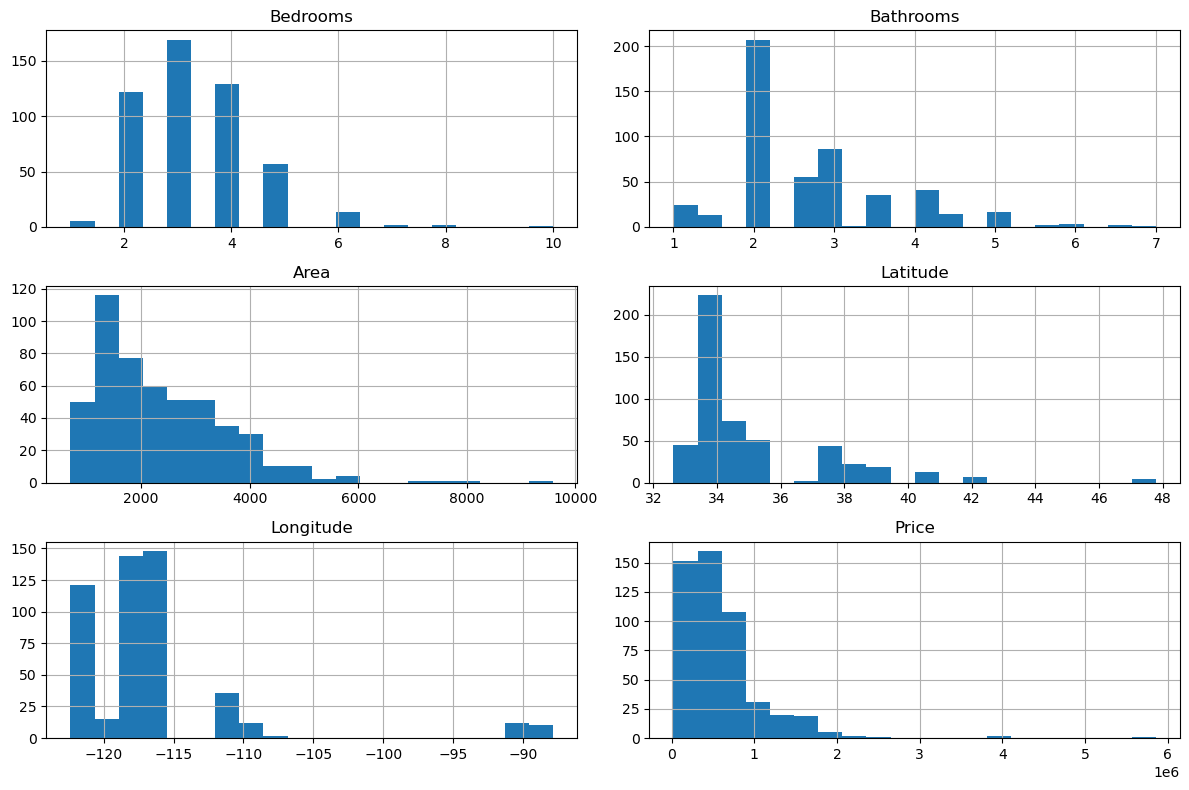

In [6]:
numeric_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "Price"]
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()


c:\Users\caspe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\caspe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


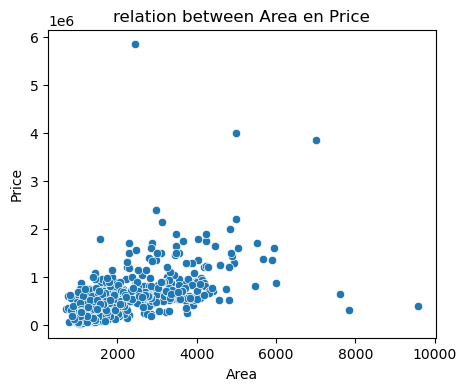

In [7]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x="Area", y="Price", data=df)
plt.title("relation between Area en Price")
plt.show()


#### Correlations

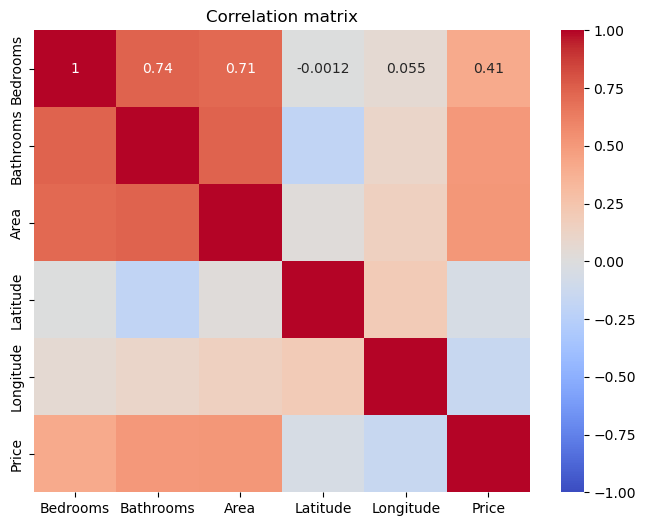

In [8]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()


#### Outliers


In [9]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
print("Amount of outliers :", outliers.shape[0])


Amount of outliers : 23


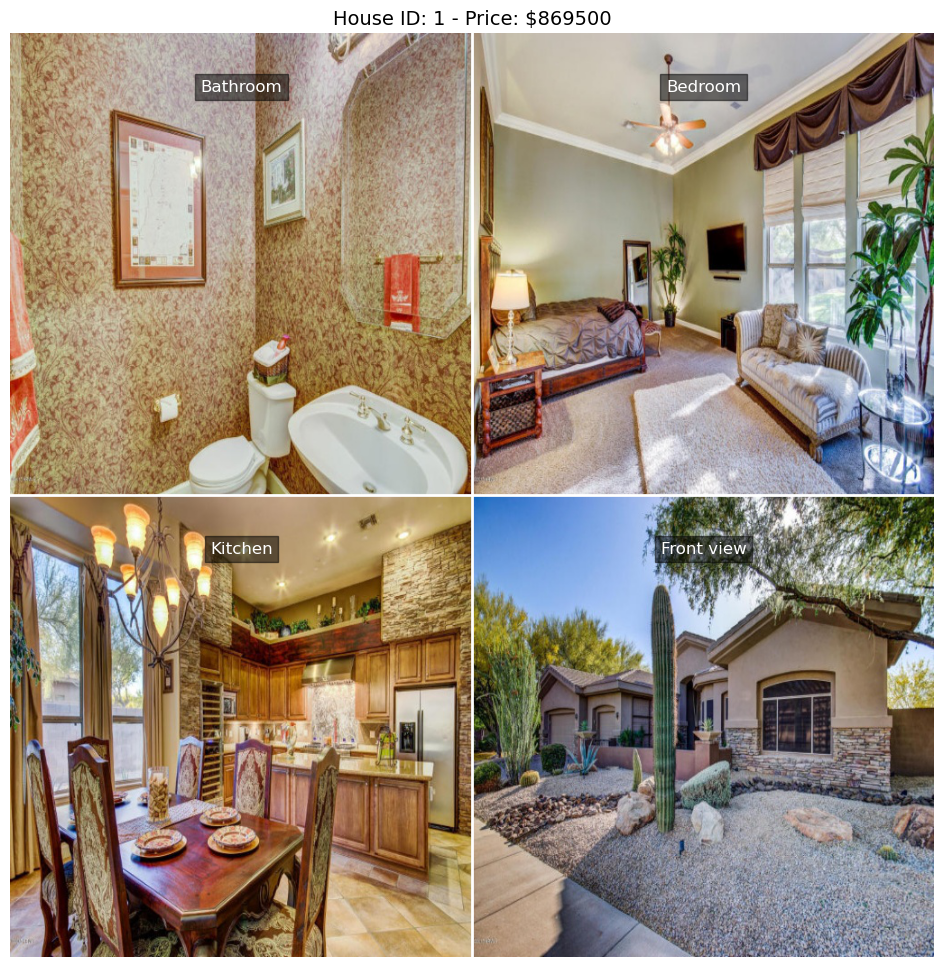

In [10]:
def display_house(house_id, df, folder='Train'):

    house_data = df.loc[df["House ID"] == house_id]
    if house_data.empty:
        print(f"House ID {house_id} Not Found")
        return
    
    num_bathrooms = house_data["Price"].values[0]
    filename = f"{house_id}.jpg"
    img_path = os.path.join(folder, filename)
    
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        return
    
    img = mpimg.imread(img_path)
    height, width, _ = img.shape
    

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title(f"House ID: {house_id} - Price: ${num_bathrooms}", fontsize=14)
    plt.axis('off')
    
    plt.axvline(x=width/2, color='white', linewidth=2)
    plt.axhline(y=height/2, color='white', linewidth=2)

    plt.text(width*0.25, height*0.05, "Bathroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.05, "Bedroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.25, height*0.55, "Kitchen",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.55, "Front view",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))

    plt.show()


display_house(1, df, folder='Train') # Display the house with ID 1, ID can be changed to any other ID


In [12]:
house_ids = df["House ID"].values

In [13]:
import cv2
def load_and_preprocess_image(house_id, folder='Train', img_size=(224, 224)):

    filename = f"{house_id}.jpg"
    path = os.path.join(folder, filename)
    
    img = cv2.imread(path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img


images = []
for hid in house_ids:
    img_array = load_and_preprocess_image(hid, folder='Train')
    images.append(img_array)

images = np.array(images)


Features for csv data

In [14]:
train = pd.read_csv('train.csv')

In [15]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


source  https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

https://chatgpt.com/share/67dfde94-77f8-800b-93cc-ffa3c0778312


In [ ]:
coastline = gpd.read_file("ne_10m_coastline.shp")
gdf_properties = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"  # WGS84 Latitude/Longitude
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
train['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

print(train.head())



c:\Users\caspe\anaconda3\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


   House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price  \
0         1         4        4.0  4053   33.6968  -111.8892  869500   
1         2         4        3.0  3343   34.8280  -119.0349  865200   
2         3         3        4.0  3923   33.7669  -111.9182  889000   
3         4         5        5.0  4022   33.7752  -111.7791  910000   
4         5         3        4.0  4116   33.7669  -111.9182  971226   

   distance_to_coast_m  
0        350887.562039  
1         77530.449791  
2        356761.999625  
3        366151.192977  
4        356761.999625  


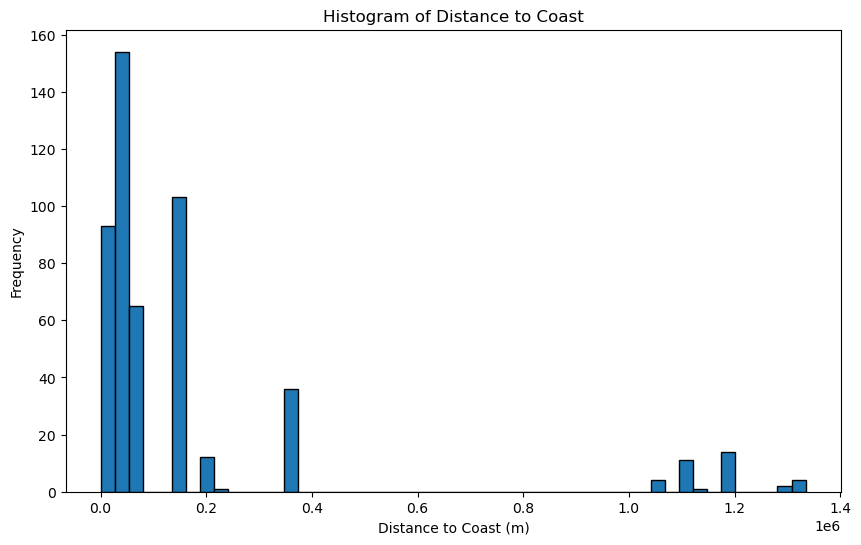

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(train['distance_to_coast_m'], bins=50, edgecolor='black')
plt.title('Histogram of Distance to Coast')
plt.xlabel('Distance to Coast (m)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
distances = np.array(train['distance_to_coast_m'])
distances_reshaped = distances.reshape(-1, 1)

# fit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(distances_reshaped)
labels = kmeans.labels_

# Create a new column in 'train' to store cluster labels
train['cluster'] = labels

# Compute mean distance for each cluster
cluster_0 = train[train['cluster'] == 0]['distance_to_coast_m']
cluster_1 = train[train['cluster'] == 1]['distance_to_coast_m']

mean_0 = cluster_0.mean()
mean_1 = cluster_1.mean()

print("Mean distance of cluster 0:", mean_0)
print("Mean distance of cluster 1:", mean_1)

mean_prices = train.groupby('cluster')['Price'].mean()
print(mean_prices)


c:\Users\caspe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\caspe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Mean distance of cluster 0: 89295.972066417
Mean distance of cluster 1: 1165174.2876889803
cluster
0    619745.497845
1    318027.750000
Name: Price, dtype: float64


In [31]:
train

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price,distance_to_coast_m,cluster
0,1,4,4.0,4053,33.6968,-111.8892,869500,350887.562039,0
1,2,4,3.0,3343,34.8280,-119.0349,865200,77530.449791,0
2,3,3,4.0,3923,33.7669,-111.9182,889000,356761.999625,0
3,4,5,5.0,4022,33.7752,-111.7791,910000,366151.192977,0
4,5,3,4.0,4116,33.7669,-111.9182,971226,356761.999625,0
...,...,...,...,...,...,...,...,...,...
495,496,2,2.0,1257,35.6406,-120.7003,380000,35044.294143,0
496,497,4,2.0,2072,35.6406,-120.7003,429900,35044.294143,0
497,498,2,2.0,2213,35.6406,-120.7003,585000,35044.294143,0
498,499,3,2.5,1500,35.6406,-120.7003,319000,35044.294143,0
